## Imports

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %run process_single_4.py --debug --verbose --recording="/data/Sandra/2019/2019_07_01/Experiment22.lif" --series="Series025" --spatial-filter="7"

In [3]:
# regions.detrend_traces

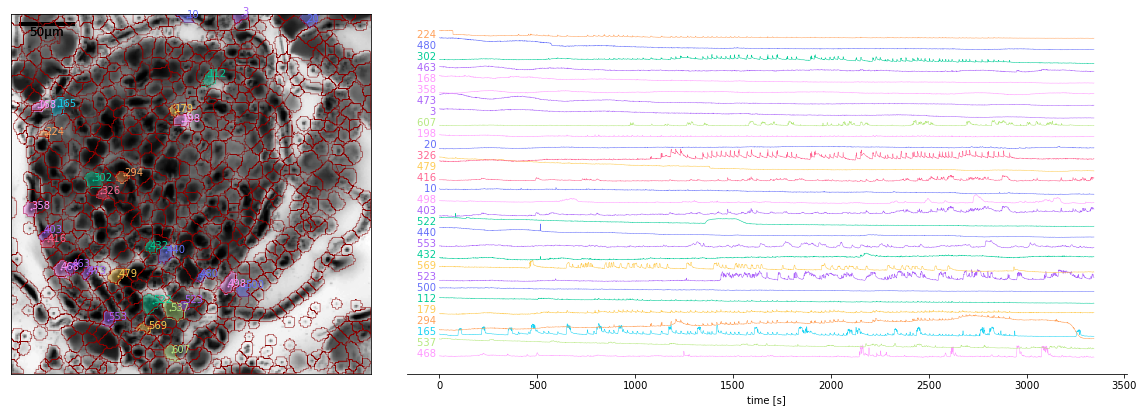

In [4]:
# regions.plotTraces(regions.df.sort_values("interest", ascending=False).index[:30])

In [5]:
from islets.Regions1 import load_regions

In [6]:
old_regions = load_regions("/data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025/6_rois.pkl")

/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:796: RuntimeWarning: invalid value encountered in true_divide
  zScore = absFast/std
/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:610: RuntimeWarning: divide by zero encountered in log
  d = np.digitize(np.log(slow_est), logbs)


In [7]:
old_regions.calc_interest()

In [12]:
# old_regions.df["color"] = ["blue"]*len(old_regions.df)
# del old_regions.df["color"]

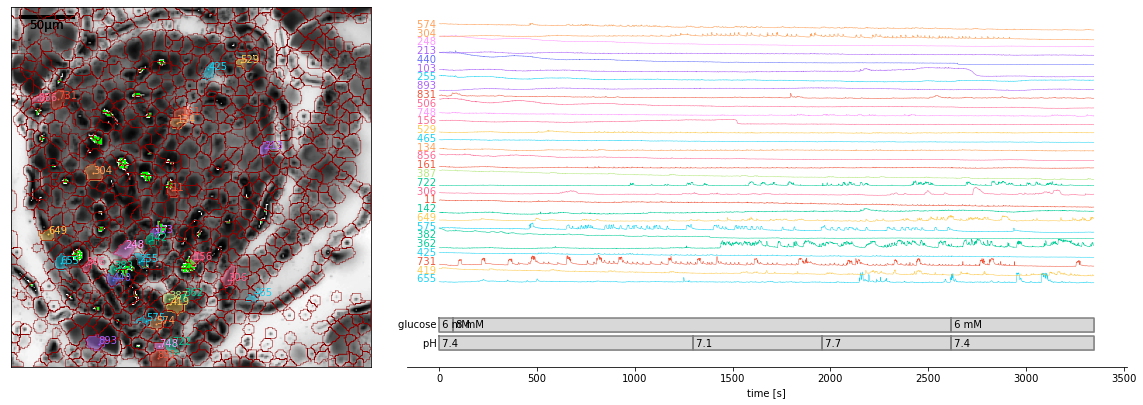

In [13]:
old_regions.plotTraces(old_regions.df.sort_values("interest", ascending=False).index[:30])

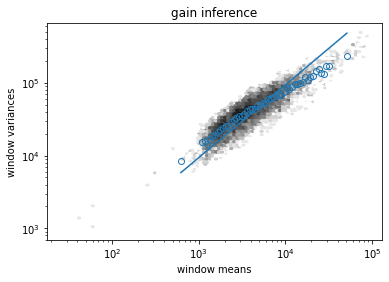

<Figure size 7560x432 with 0 Axes>

In [15]:
old_regions = load_regions("/data/Nastja/2020_11_18/Experiment3a.nd2_analysis/Experiment3a/6_rois.pkl", plot=True, verbose=True)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## importing stuff
import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import numpy as np
np.corrcoef(*np.random.randn(2,3))
import matplotlib.pyplot as plt
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from caiman import movie as cmovie
    from caiman import load  as cload

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import PicklePicker as pp
from IPython.display import display
import pandas as pd
from islets.Recording1 import Recording, saveMovie
from islets.Regions1 import Regions
from islets.numeric import power_spectrum, rebin
from islets.utils import show_movie, saveRois
from matplotlib.colors import LogNorm
from islets.Recording import import_data
from islets.Regions1 import load_regions
from islets.utils import rgb_to_hex

import bioformats as bf


In [3]:

import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from islets.Recording1 import Recording, saveMovie

In [13]:
rec = Recording("/data/Sandra/2020/2020_11_23/Experiment77a.lif")

In [14]:
rec.calc_gaps()

In [15]:
rec.metadata

,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,line scan,gap
0,Image002,1,1024,1024,1,0.455,µm,uint8,NaN,2020-11-23 13:51:05,NaT,NaT,none,NaN
1,Series003,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 13:57:06,2020-11-23 14:03:50,0 days 00:06:44.417999268,none,NaN
2,Series004,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:03:51,2020-11-23 14:10:35,0 days 00:06:44.458000183,none,1.0
3,Series005,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:10:36,2020-11-23 14:17:20,0 days 00:06:44.490999222,none,1.0
4,Series006,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:17:22,2020-11-23 14:24:06,0 days 00:06:44.521999359,none,2.0
5,Series007,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:24:07,2020-11-23 14:30:51,0 days 00:06:44.548999786,none,1.0
6,Series008,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:30:52,2020-11-23 14:37:36,0 days 00:06:44.575000763,none,1.0
7,Series009,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:37:37,2020-11-23 14:44:21,0 days 00:06:44.599000931,none,1.0
8,Series010,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:44:23,2020-11-23 14:51:07,0 days 00:06:44.618999481,none,2.0
9,Series011,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:51:08,2020-11-23 14:57:52,0 days 00:06:44.637998581,none,1.0


In [17]:
del rec.metadata["gap"]

In [22]:
rec.metadata.pxSize.loc[3:] = rec.metadata.pxSize.loc[5]

In [23]:
rec.metadata

,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,line scan
0,Image002,1,1024,1024,1,0.455,µm,uint8,NaN,2020-11-23 13:51:05,NaT,NaT,none
1,Series003,8000,512,512,1,NaN,µm,uint8,19.8,2020-11-23 13:57:06,2020-11-23 14:03:50,0 days 00:06:44.417999268,none
2,Series004,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:03:51,2020-11-23 14:10:35,0 days 00:06:44.458000183,none
3,Series005,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:10:36,2020-11-23 14:17:20,0 days 00:06:44.490999222,none
4,Series006,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:17:22,2020-11-23 14:24:06,0 days 00:06:44.521999359,none
5,Series007,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:24:07,2020-11-23 14:30:51,0 days 00:06:44.548999786,none
6,Series008,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:30:52,2020-11-23 14:37:36,0 days 00:06:44.575000763,none
7,Series009,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:37:37,2020-11-23 14:44:21,0 days 00:06:44.599000931,none
8,Series010,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:44:23,2020-11-23 14:51:07,0 days 00:06:44.618999481,none
9,Series011,8000,512,512,1,0.910,µm,uint8,19.8,2020-11-23 14:51:08,2020-11-23 14:57:52,0 days 00:06:44.637998581,none


In [24]:
rec.save_metadata()

In [3]:
import bioformats as bf

In [4]:
bf.javabridge.start_vm(class_path=bf.JARS)

In [10]:
rec.import_series("Series006", restrict=(0,10))

In [6]:
rec.Series["Series006"]["data"]

memmap([[[0, 0, 4, ..., 6, 2, 0],
         [6, 2, 1, ..., 2, 6, 4],
         [3, 0, 1, ..., 0, 1, 6],
         ...,
         [1, 6, 1, ..., 0, 4, 2],
         [0, 2, 4, ..., 2, 2, 1],
         [2, 1, 0, ..., 3, 2, 0]],

        [[2, 2, 4, ..., 4, 0, 0],
         [1, 1, 2, ..., 0, 0, 2],
         [0, 4, 0, ..., 2, 0, 0],
         ...,
         [0, 2, 0, ..., 2, 2, 5],
         [1, 0, 4, ..., 0, 2, 1],
         [2, 0, 6, ..., 0, 0, 0]],

        [[0, 2, 0, ..., 4, 1, 2],
         [0, 0, 0, ..., 2, 2, 1],
         [1, 0, 6, ..., 2, 1, 0],
         ...,
         [4, 6, 2, ..., 0, 0, 0],
         [0, 4, 2, ..., 0, 2, 0],
         [0, 4, 0, ..., 0, 2, 4]],

        ...,

        [[4, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 1, 1],
         [1, 0, 0, ..., 2, 4, 4],
         ...,
         [2, 6, 4, ..., 0, 2, 1],
         [2, 3, 0, ..., 2, 0, 1],
         [1, 4, 1, ..., 0, 2, 0]],

        [[0, 0, 2, ..., 1, 4, 4],
         [1, 0, 0, ..., 1, 0, 0],
         [3, 2, 4, ..., 4, 0, 1],
    

In [11]:
del rec

In [12]:
rec  = Recordingrding("")

TypeError: __init__() missing 1 required positional argument: 'pathToExperiment'

In [6]:
np.memmap?

In [2]:
# %run process_single_4.py -rec="/data/Nastja/2020_11_18/Experiment3a.nd2" -ser="Series025" --verbose --debug --restrict="10_500" --spatial-filter="5" --leave-movie

In [3]:
# %run process_single_4.py -rec="/data/Nastja/2020_11_18/Experiment3a.nd2" --only-movie

In [5]:
import_data("/data/Sandra/2020")

Recording /data/Sandra/2020/2020_11_19/Experiment76.lif not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... 


/home/jupyter-srdjan/srdjan_functs/islets/Recording.py:135: UserWarning: Could not parse metadata. (<class 'AttributeError'>, AttributeError("'NoneType' object has no attribute 'find_class'"), <traceback object at 0x7f081376c280>)
  warn(f"Could not parse metadata. {exc_info()}")


AttributeError: 'Recording' object has no attribute 'metadata'

In [16]:
regions = load_regions(regions.pathToPickle, mergeDist=0)

In [4]:
# regions.plotTraces(regions.df.index, col="trace")

In [7]:
del regions.metadata

300 subsumed into existing ROIs.
106 subsumed into existing ROIs.


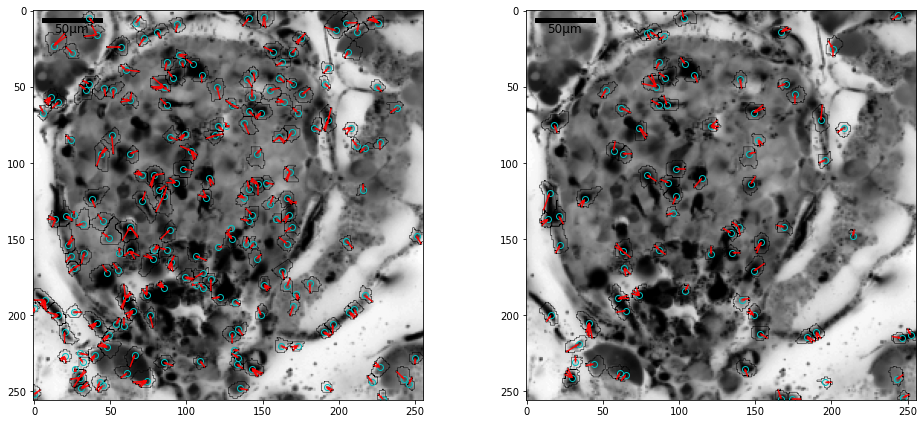

In [17]:
regions.merge_closest(plot=True, Niter=2, verbose=True)

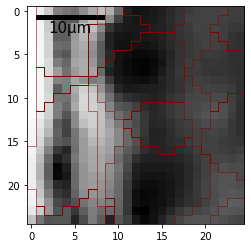

In [3]:
regions.plotEdges()

In [2]:
# saveMovie(movie,"embed")

In [4]:
from IPython.display import Video
Video(movieFilename, embed=True)

In [9]:
HTML(f"""
    <video alt="test" width="320" height="240" controls>
        <source src="{movieFilename}" type="video/mp4">
    </video>
""")


In [2]:
rec = Recording()

In [3]:
serToImport = "Series025"

In [4]:
restrict = (10,-3000)

In [5]:
bf.javabridge.start_vm(class_path=bf.JARS)
rec.import_series(serToImport, restrict=restrict)
bf.javabridge.kill_vm()

In [13]:
movie = cmovie(
    rec.Series[serToImport]["data"],
    fr = rec.Series[serToImport]["metadata"]["Frequency"],
              )

In [14]:
metadata = rec.Series[serToImport]["metadata"]

In [15]:
# show_movie(movie[:,::2,::2].astype("float32")+1, autoadjust=False, log=True)

In [16]:
movie = movie.resize(.5,.5,1)

In [17]:
show_movie(movie[:3])

In [12]:
metadata.pxSizeze

AttributeError: 'Series' object has no attribute 'pxSizeze'

In [18]:
#     if len(pathToCorrected):
#         movie = cload(
#             pathToCorrected,
#             fr=metadata.Frequency,
#             outtype=metadata['bit depth']
#         )
#         FrameRange = metadata.frame_range
#         movie = movie[FrameRange[0]:FrameRange[1]]
#     else:
#         movie = cmovie(
#             rec.Series[serToImport]['data'],
#             fr=metadata.Frequency
#         )

In [27]:
# ser = serToImport

In [28]:
saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)

In [29]:
if len(rec.metadata)==1:
    movieFilename = os.path.join(saveDir, os.path.splitext(rec.Experiment)[0]+".mp4")
else:
    movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")

In [42]:
movie.fr = None

In [31]:
# metadata.pxSize

In [ ]:
def process_movie(movie, metadata, test=False, debug=False, verbose=0):
    


    if metadata.pxSize<.8:
        if args.verbose: print ("Resizing the movie resolution by 2...")
        movie = movie.resize(1/2,1/2,1)
        metadata.pxSize *= 2
        metadata.SizeX /= 2
        metadata.SizeY /= 2

    writeMovie = True
    if os.path.isfile(movieFilename):
        if args.verbose: print("Movie already exists, ", end="")
        if args.leave_movie:
            writeMovie = False
            if args.verbose: print("and I leave it be.")
        else:
            if args.verbose: print("and I'll rewrite it.")
    if writeMovie:
        if args.verbose: print("Writing the movie...")
        if not args.test: saveMovie(movie,movieFilename)

    if not args.only_movie: 


        #### protocol filename
        protocolFilename = movieFilename.replace(".mp4", "_protocol.txt")
        if not os.path.isfile(protocolFilename):
            if args.verbose: print("placed dummy protocol file at", protocolFilename)
            if not args.test:
                DataFrame([[None]*4],columns=["compound","concentration","begin","end"]).to_csv(protocolFilename,index=False)

        filtSizes = get_filterSizes(metadata.pxSize)

        # anull saturated above threshold
#         Nsatur = (movie==movie.max()).sum(0)
#         toAnull = np.where(Nsatur>len(movie)*fracSaturTh)
#         movie[(slice(None), )+toAnull] = 0


        for spFilt in filtSizes:
            if args.verbose: print ("\t"*2,"#"*5,spFilt)

            pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
            if os.path.isfile(pickleFile) and args.leave_pickles:
                if args.verbose: print ("already exists, skipping.")
                continue
            else:
                if args.verbose: print ("processing with filter size of ", spFilt)

            regions = Regions(movie,gSig_filt=spFilt,diag=True)
            regions.time += t0
            if args.verbose:
                print (f"initiallized with {len(regions.df)} rois.")

            regions.purge_lones((min(spFilt)*.4)**2, verbose=args.verbose)
            regions.sortFromCenter()
            regions.calcTraces()
            regions.metadata = metadata
            if not args.test: 
                saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])

            # preview image
            del regions